In [1]:
import random
import logging
import numpy as np
import torch
import csv
from tqdm import tqdm
from pytorchfi import core
from finetune import Ground_truth_model
from errors import stuck_at_one, stuck_at_zero, bit_flip
import bitflips
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from modified_fi import ModifiedFaultInjection
from collections import defaultdict

In [ ]:
class Perturbed_model:
    def __init__(self,model_,tokenizer,batch_size,input_shape,layer_types,use_cuda=False):
        self.ground_truth=model_
        self.inj_model=ModifiedFaultInjection(
            model=model_.model,
            batch_size=batch_size,
            input_shape=input_shape,
            layer_types=layer_types,
            use_cuda=use_cuda
        )
        self.tokenizer=tokenizer
    def setup(self):
        self.inj_model._traverse_model_set_hooks()
        print(self.inj_model.print_pytorchfi_layer_summary)
    def experiment(self,test_loader,n=1):
        layer_accs = defaultdict(list)
        accuracies=[]
        for i in tqdm(range(n)):
            for i in range(0,self.inj_model.get_total_layers()):
           
                corrupted_model = bitflips.random_inj_one_layer_batched(self.inj_model,layer_given=i)
                
                print("Finished injection, beginning evaluation.")
                # Evaluate the faulty model
                accuracy = self.evaluate(corrupted_model, test_loader)
                print("Finished evaluation.")
                layer_accs[i].append(accuracy)
                
                # Reset the fault injection for the next iteration
                self.inj_model.fi_reset()

        # Visualize the accuracy results
        sorted_layers = sorted(layer_accs.keys())
        avg_accs = [np.mean(layer_accs[layer]) for layer in sorted_layers]
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_layers, avg_accs, marker='o')
        plt.xlabel("Layer Number")
        plt.ylabel("Average Accuracy (%)")
        plt.title(f"Average Accuracy vs Layer Number")
        plt.grid(True)
        plt.xticks(sorted_layers)
        plt.show()
        '''plt.plot(range(n), accuracies, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Under Fault Injections')
        plt.show()'''
    def evaluate(self, model, dataloader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print("Model on device.")
        model.eval()
        print("Placed in eval mode.")

        total, correct = 0, 0
        print("Beginning Evaluation.")
        with torch.no_grad():
            for batch in dataloader:

                input_ids, attention_mask, labels = (t.to(device) for t in batch)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                self.inj_model.reset_current_layer()


        accuracy = 100 * correct / total
        return accuracy


In [3]:
class IMDbDataset(Dataset):
    def __init__(self, tokenizer, split="train", max_length=128):
        self.dataset = load_dataset("imdb", split=split)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]["text"]
        label = self.dataset[idx]["label"]
        inputs = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )
        return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0), torch.tensor(label)


In [4]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model.load_state_dict(torch.load("rnn_model.pt", weights_only=True))
ground_truth = Ground_truth_model(model,tokenizer)


train_dataset = IMDbDataset(ground_truth.tokenizer, split="train[:5000]")  
test_dataset = IMDbDataset(ground_truth.tokenizer, split="test[:992]")    


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

accuracy=ground_truth.evaluate(test_dataloader)
print(f"Initial accuracy on IMDb test set: {accuracy:.2f}%")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initial accuracy on IMDb test set: 100.00%


In [5]:
print(ground_truth.model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
class WrappedBERT(torch.nn.Module):
    def __init__(self, model):
        super(WrappedBERT, self).__init__()
        self.model = model

    def forward(self, input_ids):
        attention_mask = (input_ids != 0).long()  # Assume padding token ID is 0
        return self.model(input_ids=input_ids, attention_mask=attention_mask)
    
wrapped_bert = WrappedBERT(ground_truth.model)

In [7]:
perturb_model = Perturbed_model(wrapped_bert,ground_truth.tokenizer,batch_size=16, input_shape=[128],layer_types=[torch.nn.Linear])
# print(len(perturb_model.inj_model.layers_dim))
# print(perturb_model.inj_model.corrupt_layer)
# print(perturb_model.inj_model.print_pytorchfi_layer_summary())
# perturb_model.experiment(test_dataloader)

In [8]:
print(len(perturb_model.inj_model.output_size))


38


  0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Finished injection, beginning evaluation.
Model on device.
Placed in eval mode.
Beginning Evaluation.
Finished evaluation.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
1

100%|██████████| 1/1 [06:30<00:00, 390.69s/it]

Finished evaluation.


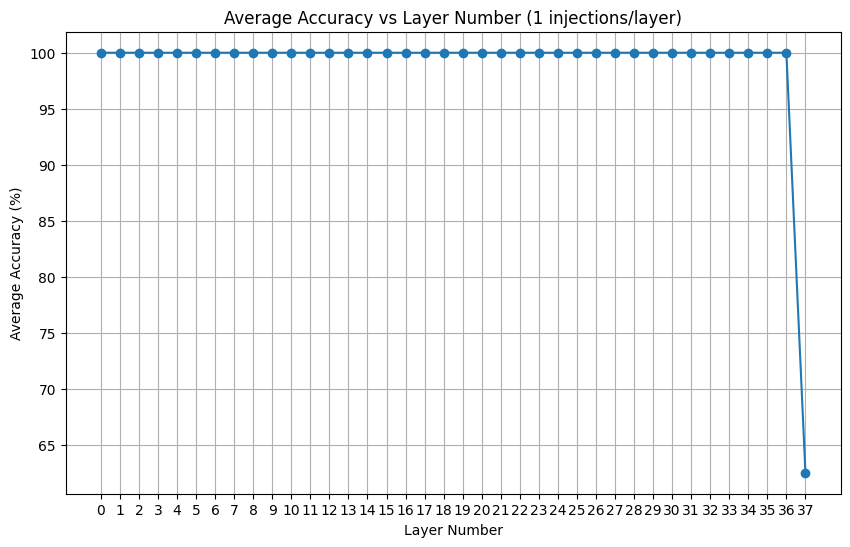

In [9]:
perturb_model.experiment(test_dataloader)

In [10]:
print(f"Number of injectable layers: {len(perturb_model.inj_model.layers_type)}")

Number of injectable layers: 38


In [11]:
print("Output size:", perturb_model.inj_model.output_size)

Output size: [[1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 768], [1, 128, 3072], [1, 128, 768], [1, 768], [1, 2]]


In [12]:
print("Total batches:", perturb_model.inj_model.get_total_batches())

Total batches: 16


In [13]:
for batch in test_dataloader:
    print(batch[0].size())

torch.Size([16, 128])


torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size